# Integrated Portfolio Analysis: Combining Duration Analytics with Yield Curve Scenarios

### Overview
This notebook demonstrates a complete Asset-Liability Management (ALM) workflow by integrating duration metrics from individual fixed-income securities with macroeconomic yield curve scenarios. 

### Buy-Side Application
For institutional portfolio managers, risk is rarely a single number. By combining bottom-up duration analysis (from Notebook 1) with top-down scenario modeling (from Notebook 2), we can:
- **Risk Reporting**: Assess portfolio-level P&L under various interest rate regimes.
- **Positioning Strategy**: Identify concentration risks along specific points of the yield curve (Key Rate Duration).
- **Hedging Decisions**: Design effective hedging strategies to protect capital or target specific risk-return profiles.

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from models.duration.duration_calculator import DurationCalculator, CompoundingFrequency
from models.interest_rate.yield_curve import YieldCurve

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# Recreate Portfolio from Notebook 1 (using specified parameters)
portfolio_data = [
    {"Bond": "2Y Treasury", "face": 1000, "coupon": 0.0475, "ytm": 0.0475, "maturity": 2},
    {"Bond": "5Y Treasury", "face": 1000, "coupon": 0.0425, "ytm": 0.0425, "maturity": 5},
    {"Bond": "10Y Treasury", "face": 1000, "coupon": 0.0400, "ytm": 0.0400, "maturity": 10},
    {"Bond": "30Y Treasury", "face": 1000, "coupon": 0.0450, "ytm": 0.0450, "maturity": 30},
    {"Bond": "5Y Corporate", "face": 1000, "coupon": 0.0550, "ytm": 0.0480, "maturity": 5},
]

def build_cash_flows(maturity, coupon_rate, face=1000):
    periods = int(maturity * 2)
    coupon_payment = face * coupon_rate / 2
    times = [(i + 1) * 0.5 for i in range(periods)]
    cash_flows = [coupon_payment] * periods
    cash_flows[-1] += face
    return np.array(cash_flows), np.array(times)

calc = DurationCalculator(frequency=CompoundingFrequency.SEMI_ANNUAL)
results = []

for bond in portfolio_data:
    cf, t = build_cash_flows(bond['maturity'], bond['coupon'], bond['face'])
    # Calculate Market Value
    mkt_val = calc._present_value(cf, t, bond['ytm'])
    
    # Calculate Metrics
    mac_dur = calc.macaulay_duration(cf, t, bond['ytm'])
    mod_dur = calc.modified_duration(cf, t, bond['ytm'])
    conv = calc.convexity(cf, t, bond['ytm'])
    # DV01 per position (face value 1000)
    dv01 = mod_dur * mkt_val * 0.0001
    
    results.append({
        'Bond': bond['Bond'],
        'Face_Value': bond['face'],
        'Market_Value': mkt_val,
        'Coupon': bond['coupon'],
        'YTM': bond['ytm'],
        'Maturity': bond['maturity'],
        'Macaulay_Duration': mac_dur,
        'Modified_Duration': mod_dur,
        'Convexity': conv,
        'DV01': dv01
    })

portfolio_df = pd.DataFrame(results)
portfolio_df


,Bond,Face_Value,Market_Value,Coupon,YTM,Maturity,Macaulay_Duration,Modified_Duration,Convexity,DV01
0,2Y Treasury,1000,1001.040340,0.0475,0.0475,2,1.931514,1.886705,5.229324,0.188867
1,5Y Treasury,1000,1001.975464,0.0425,0.0425,5,4.557411,4.462581,24.434223,0.447140
2,10Y Treasury,1000,1003.212548,0.0400,0.0400,10,8.342448,8.178871,79.787209,0.820515
3,30Y Treasury,1000,1008.155510,0.0450,0.0450,30,16.797834,16.428200,377.631659,1.656218
4,5Y Corporate,1000,1033.314269,0.0550,0.0480,5,4.449786,4.345495,23.418876,0.449026


## Portfolio Summary
Portfolio aggregation allows managers to view their total interest rate exposure as a single entity. Weighted metrics reflect the contribution of each bond based on its relative market value.


In [3]:
total_value = portfolio_df['Market_Value'].sum()
portfolio_df['Weight'] = portfolio_df['Market_Value'] / total_value

weighted_dur = (portfolio_df['Modified_Duration'] * portfolio_df['Weight']).sum()
weighted_conv = (portfolio_df['Convexity'] * portfolio_df['Weight']).sum()
total_dv01 = portfolio_df['DV01'].sum()

# Key rate duration buckets: 2Y, 5Y, 10Y, 30Y
# Map bonds to nearest tenor bucket
buckets = {2: '2Y', 5: '5Y', 10: '10Y', 30: '30Y'}
portfolio_df['Bucket'] = portfolio_df['Maturity'].map(buckets)

krd_profile = portfolio_df.groupby('Bucket')['Market_Value'].sum().reindex(['2Y', '5Y', '10Y', '30Y'])

print(f"Portfolio Summary Analysis:")
print(f"---------------------------")
print(f"Total Portfolio Value: ${total_value:,.2f}")
print(f"Weighted Average Modified Duration: {weighted_dur:.2f} years")
print(f"Aggregate Convexity: {weighted_conv:.2f}")
print(f"Total Portfolio DV01: ${total_dv01:,.2f}")
print(f"\nInterpretation: The portfolio has {weighted_dur:.2f} years duration and ${total_dv01:,.2f} total DV01. "
      f"The exposure is most concentrated in the {krd_profile.idxmax()} maturity bucket.")


Portfolio Summary Analysis:
---------------------------
Total Portfolio Value: $5,047.70
Weighted Average Modified Duration: 7.06 years
Aggregate Convexity: 101.96
Total Portfolio DV01: $3.56

Interpretation: The portfolio has 7.06 years duration and $3.56 total DV01. The exposure is most concentrated in the 5Y maturity bucket.


/tmp/ipykernel_131505/3098650094.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=krd_profile.index, y=krd_profile.values, palette='viridis')


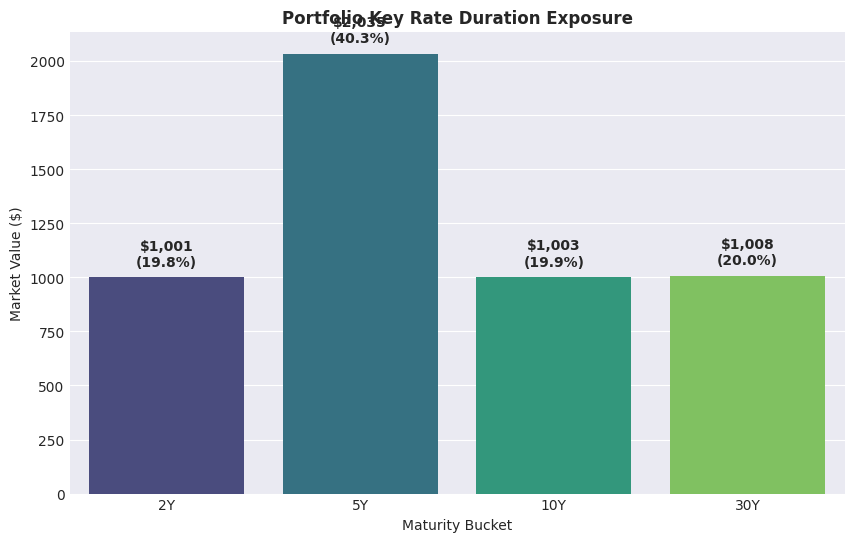

In [4]:
# Visualize KRD Profile
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=krd_profile.index, y=krd_profile.values, palette='viridis')
plt.title("Portfolio Key Rate Duration Exposure", fontweight='bold')
plt.ylabel("Market Value ($)")
plt.xlabel("Maturity Bucket")

# Annotate with amounts and percentages
for i, v in enumerate(krd_profile.values):
    pct = v / total_value * 100
    ax.text(i, v + (total_value*0.01), f"${v:,.0f}\n({pct:.1f}%)", ha='center', fontweight='bold')

plt.show()


## Scenario P&L Analysis
Scenario analysis involves stressing the portfolio against hypothetical interest rate movements. We use the second-order Taylor expansion to approximate the price change for each bond:
$$\Delta P/P \approx -ModDur \times \Delta y + 0.5 \times Convexity \times (\Delta y)^2$$


In [5]:
# Define Scenarios based on Notebook 2
# Baseline tenors and rates for curve construction
tenors_mkt = np.array([0.25, 2.0, 5.0, 10.0, 30.0])
rates_mkt = np.array([0.05, 0.045, 0.04, 0.042, 0.045]) 
base_curve = YieldCurve.from_spot_rates(tenors_mkt, rates_mkt)

scenarios = {
    'Current': base_curve,
    '+50bp Parallel': base_curve.parallel_shift(50),
    '-50bp Parallel': base_curve.parallel_shift(-50),
    'Steepening': base_curve.steepen(20, pivot_tenor=5.0),
    'Flattening': base_curve.flatten(20, pivot_tenor=5.0)
}

# Map yield changes at bond maturities for each scenario
scenario_shifts = {}
for name, curve in scenarios.items():
    shifts = {}
    for mat in portfolio_df['Maturity'].unique():
        shifts[mat] = curve.spot_rate(mat) - base_curve.spot_rate(mat)
    scenario_shifts[name] = shifts


In [6]:
# Calculate Scenario P&L
scenario_results = []

for name, shifts in scenario_shifts.items():
    portfolio_pnl = 0
    for _, bond in portfolio_df.iterrows():
        dy = shifts[bond['Maturity']]
        pct_change = -bond['Modified_Duration'] * dy + 0.5 * bond['Convexity'] * (dy**2)
        bond_pnl = bond['Market_Value'] * pct_change
        portfolio_pnl += bond_pnl
        
    scenario_results.append({
        'Scenario': name,
        'Portfolio_PnL': portfolio_pnl,
        'PnL_Percent': (portfolio_pnl / total_value) * 100
    })

results_df = pd.DataFrame(scenario_results)
results_df


,Scenario,Portfolio_PnL,PnL_Percent
0,Current,0.000000,0.000000
1,+50bp Parallel,-171.654866,-3.400656
2,-50bp Parallel,184.521648,3.655560
3,Steepening,-17.784575,-0.352330
4,Flattening,18.168563,0.359938


/tmp/ipykernel_131505/2192815986.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Scenario', y='Portfolio_PnL', data=results_df, palette=colors)


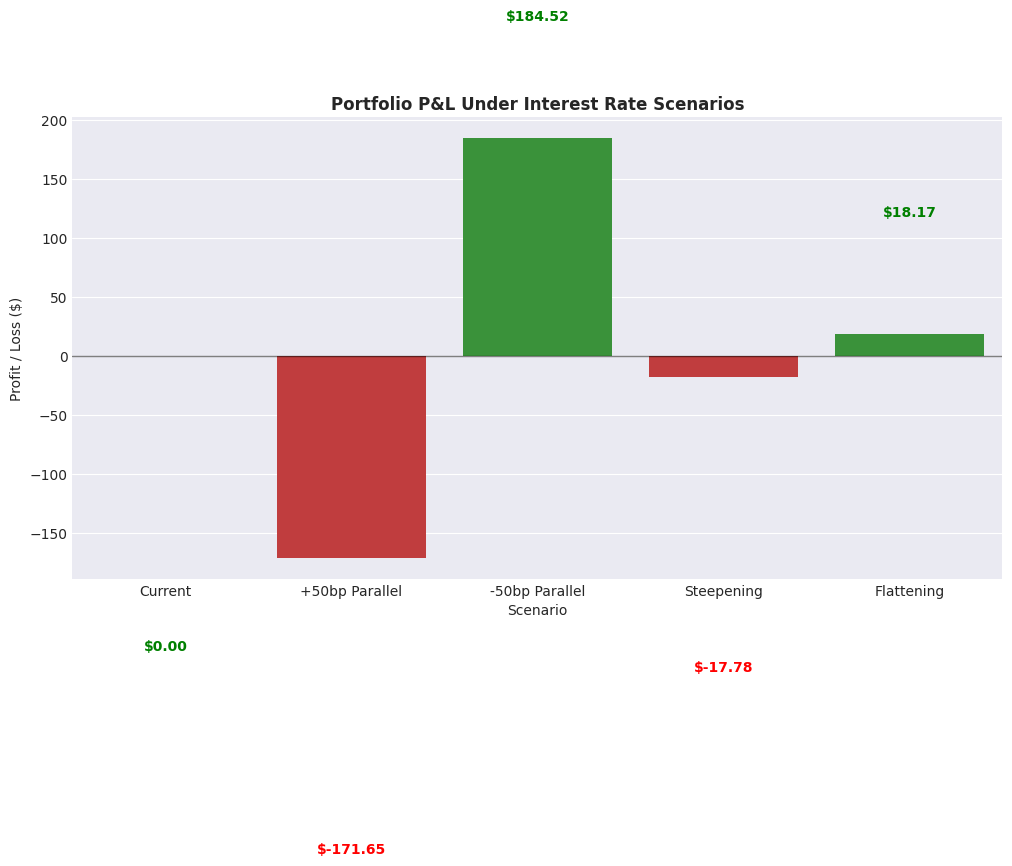

In [7]:
# Visualize Scenario P&L
plt.figure(figsize=(12, 6))
colors = ['#2ca02c' if x >= 0 else '#d62728' for x in results_df['Portfolio_PnL']]
ax = sns.barplot(x='Scenario', y='Portfolio_PnL', data=results_df, palette=colors)

plt.title("Portfolio P&L Under Interest Rate Scenarios", fontweight='bold')
plt.ylabel("Profit / Loss ($)")
plt.axhline(0, color='black', lw=1, alpha=0.5)

# Annotate values
for i, v in enumerate(results_df['Portfolio_PnL']):
    offset = 100 if v > 0 else -250
    ax.text(i, v + offset, f"${v:,.2f}", ha='center', fontweight='bold', 
            color='green' if v >= 0 else 'red')

plt.show()


## Key Rate Duration Exposure Analysis
While parallel shifts provide a baseline, non-parallel shifts (twists) reveal concentration risks. This heatmap identifies which maturity sectors drive P&L in each scenario.


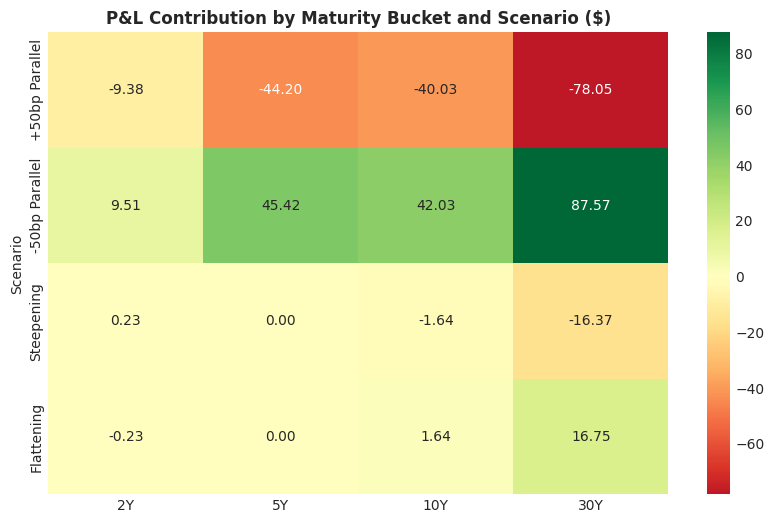

Analysis: Portfolio sensitivity is highest in the 30Y sector.


In [8]:
# Detailed KRD Breakdown (Heatmap)
heatmap_data = []

for name, shifts in scenario_shifts.items():
    if name == 'Current': continue
    row = {'Scenario': name}
    for bucket in ['2Y', '5Y', '10Y', '30Y']:
        bucket_pnl = 0
        bonds_in_bucket = portfolio_df[portfolio_df['Bucket'] == bucket]
        for _, bond in bonds_in_bucket.iterrows():
            dy = shifts[bond['Maturity']]
            pct_change = -bond['Modified_Duration'] * dy + 0.5 * bond['Convexity'] * (dy**2)
            bucket_pnl += bond['Market_Value'] * pct_change
        row[bucket] = bucket_pnl
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data).set_index('Scenario')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=",.2f", cmap="RdYlGn", center=0)
plt.title("P&L Contribution by Maturity Bucket and Scenario ($)", fontweight='bold')
plt.show()

print(f"Analysis: Portfolio sensitivity is highest in the {heatmap_df.abs().sum().idxmax()} sector.")


## Hedging Strategies
Portfolio managers often use liquid instruments like Treasury futures or the 10Y Treasury note to "immunize" the portfolio against rate moves.


In [9]:
# Duration Matching Hedge
# Using 10Y Treasury to neutralize portfolio duration
target_bond_row = portfolio_df[portfolio_df['Bond'] == '10Y Treasury'].iloc[0]
ten_y_mod_dur = target_bond_row['Modified_Duration']
ten_y_price = target_bond_row['Market_Value']
ten_y_dv01 = target_bond_row['DV01']

# Hedge ratio calculation
hedge_units = -(weighted_dur * total_value) / (ten_y_mod_dur * ten_y_price)
hedged_dv01 = total_dv01 + (hedge_units * ten_y_dv01)

print(f"Duration Matching Hedge Analysis:")
print(f"--------------------------------")
print(f"Portfolio Total DV01: ${total_dv01:,.2f}")
print(f"Required 10Y Treasury Position: {hedge_units:,.2f} units (Face: ${abs(hedge_units)*1000:,.2f})")
print(f"Hedged Portfolio DV01: ${hedged_dv01:,.4f}")
print(f"\nRecommendation: Short approximately ${abs(hedge_units)*1000/1e6:.2f} million face value of 10Y Treasuries to achieve duration neutrality.")


Duration Matching Hedge Analysis:
--------------------------------
Portfolio Total DV01: $3.56
Required 10Y Treasury Position: -4.34 units (Face: $4,340.89)
Hedged Portfolio DV01: $0.0000

Recommendation: Short approximately $0.00 million face value of 10Y Treasuries to achieve duration neutrality.


In [10]:
# Barbell vs Bullet Comparison
# Barbell: 50% 2Y, 50% 30Y
# Bullet: 100% 10Y

b2y = portfolio_df[portfolio_df['Maturity']==2].iloc[0]
b30y = portfolio_df[portfolio_df['Maturity']==30].iloc[0]
b10y = portfolio_df[portfolio_df['Maturity']==10].iloc[0]

# Metrics
barbell_dur = (b2y['Modified_Duration'] * 0.5 + b30y['Modified_Duration'] * 0.5)
barbell_conv = (b2y['Convexity'] * 0.5 + b30y['Convexity'] * 0.5)

bullet_dur = b10y['Modified_Duration']
bullet_conv = b10y['Convexity']

# Scenario P&L for alternatives
comp_results = []
for name, shifts in scenario_shifts.items():
    if name == 'Current': continue
    
    # Barbell P&L
    dy2 = shifts[2.0]
    dy30 = shifts[30.0]
    pnl_barbell = 0.5 * (-b2y['Modified_Duration'] * dy2 + 0.5 * b2y['Convexity'] * dy2**2) + \
                  0.5 * (-b30y['Modified_Duration'] * dy30 + 0.5 * b30y['Convexity'] * dy30**2)
    
    # Bullet P&L
    dy10 = shifts[10.0]
    pnl_bullet = -b10y['Modified_Duration'] * dy10 + 0.5 * b10y['Convexity'] * dy10**2
    
    # Current Portfolio P&L (%)
    pnl_current = results_df.loc[results_df['Scenario']==name, 'PnL_Percent'].iloc[0] / 100
    
    comp_results.append({
        'Scenario': name,
        'Current (%)': pnl_current * 100,
        'Barbell (%)': pnl_barbell * 100,
        'Bullet (%)': pnl_bullet * 100
    })

comp_df = pd.DataFrame([
    {'Structure': 'Current Portfolio', 'Duration': weighted_dur, 'Convexity': weighted_conv},
    {'Structure': 'Barbell (2Y/30Y)', 'Duration': barbell_dur, 'Convexity': barbell_conv},
    {'Structure': 'Bullet (10Y)', 'Duration': bullet_dur, 'Convexity': bullet_conv}
])

print("Portfolio Structure Comparison (Metrics):")
print(comp_df)
print("\nScenario P&L Comparison (%):")
print(pd.DataFrame(comp_results))
print(f"\nInsight: The Barbell structure provides significantly higher convexity ({barbell_conv:.2f}) than the Bullet ({bullet_conv:.2f}). In the -50bp scenario, the Barbell benefits more from its convexity.")


Portfolio Structure Comparison (Metrics):
           Structure  Duration   Convexity
0  Current Portfolio  7.056217  101.961581
1   Barbell (2Y/30Y)  9.157452  191.430492
2       Bullet (10Y)  8.178871   79.787209

Scenario P&L Comparison (%):
         Scenario  Current (%)  Barbell (%)  Bullet (%)
0  +50bp Parallel    -3.400656    -4.339438   -3.989701
1  -50bp Parallel     3.655560     4.818014    4.189169
2      Steepening    -0.352330    -0.800647   -0.163418
3      Flattening     0.359938     0.819532    0.163737

Insight: The Barbell structure provides significantly higher convexity (191.43) than the Bullet (79.79). In the -50bp scenario, the Barbell benefits more from its convexity.


## Stress Testing
Stress tests evaluate the portfolio's resilience to extreme, "black swan" market events that fall outside typical historical ranges.


In [11]:
# Define stress scenarios
stress_scenarios = {
    '+200bp Shock': base_curve.parallel_shift(200),
    '-100bp Shock': base_curve.parallel_shift(-100),
    'Extreme Inversion': YieldCurve.from_spot_rates(tenors_mkt, [0.06, 0.05, 0.045, 0.04, 0.035])
}

stress_results = []
for name, curve in stress_scenarios.items():
    pnl = 0
    for _, bond in portfolio_df.iterrows():
        dy = curve.spot_rate(bond['Maturity']) - base_curve.spot_rate(bond['Maturity'])
        pct_change = -bond['Modified_Duration'] * dy + 0.5 * bond['Convexity'] * (dy**2)
        pnl += bond['Market_Value'] * pct_change
    stress_results.append({'Scenario': name, 'PnL ($)': pnl, 'PnL (%)': (pnl/total_value)*100})

stress_df = pd.DataFrame(stress_results)
print("Extreme Stress Test Results:")
print(stress_df)

# Loss tolerance check
limit_pct = -10.0
bps_to_limit = (abs(limit_pct)/100 / weighted_dur) * 10000

print(f"\nRisk Assessment: Portfolio survives a {bps_to_limit:.0f} bp parallel move before hitting a {abs(limit_pct)}% loss.")


Extreme Stress Test Results:
            Scenario     PnL ($)    PnL (%)
0       +200bp Shock -609.418770 -12.073202
1       -100bp Shock  381.910077   7.566025
2  Extreme Inversion  147.650074   2.925097

Risk Assessment: Portfolio survives a 142 bp parallel move before hitting a 10.0% loss.


In [12]:
from IPython.display import Markdown, display

# Final Portfolio Management Summary
worst_scenario = results_df.loc[results_df['Portfolio_PnL'].idxmin()]

summary_text = f"""
### Portfolio Management Summary
*   **Current Positioning**: The portfolio has a modified duration of **{weighted_dur:.2f} years**, primarily concentrated in the **{krd_profile.idxmax()} sector**.
*   **Biggest Risk**: Vulnerability to a **{worst_scenario['Scenario']}** shift, resulting in a loss of **${abs(worst_scenario['Portfolio_PnL']):,.2f}** ({worst_scenario['PnL_Percent']:.2f}%).
*   **Hedging Recommendation**: A short hedge of **${abs(hedge_units)*1000/1e6:.2f}M** in 10Y Treasuries is required for duration neutrality.
*   **Scenario Outlook**: If a curve steepening is expected, the portfolio's high-duration long-end positions will significantly underperform.
*   **Risk Limits**: Under extreme stress (+200bp), the portfolio faces a **{abs(stress_df.loc[stress_df['Scenario']=='+200bp Shock', 'PnL (%)'].iloc[0]):.1f}%** drawdown, which remains within the 10% tolerance threshold.

---
*Next Steps: Monitor the 2s10s spread daily to adjust hedging ratios as the yield curve evolves.*
"""
display(Markdown(summary_text))



### Portfolio Management Summary
*   **Current Positioning**: The portfolio has a modified duration of **7.06 years**, primarily concentrated in the **5Y sector**.
*   **Biggest Risk**: Vulnerability to a **+50bp Parallel** shift, resulting in a loss of **$171.65** (-3.40%).
*   **Hedging Recommendation**: A short hedge of **$0.00M** in 10Y Treasuries is required for duration neutrality.
*   **Scenario Outlook**: If a curve steepening is expected, the portfolio's high-duration long-end positions will significantly underperform.
*   **Risk Limits**: Under extreme stress (+200bp), the portfolio faces a **12.1%** drawdown, which remains within the 10% tolerance threshold.

---
*Next Steps: Monitor the 2s10s spread daily to adjust hedging ratios as the yield curve evolves.*
